# Classifiers Using scikit-learn

## The __No Free Lunch Theorom__
No single classifier works best across all possible scenarios.

Five main steps invovled in training a supervised machine learning algorithm:

1) Selecting features and collecting labeled training examples.
2) Choosing a performance metric.
3) Choosing a classifier and optimization algorithm.
4) Evaluating the performance of the model.
5) Tuning the algorithm.

## The perceptron, using scikit-learn
We will train a perceptron model similar to the one I implemented in the previous notebook, but this time we will use the scikit-learn implementation. Once again, we use the iris dataset, wchich can be accessed directly from scikit-learn.

In [41]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# setosa, versicolor and virginica is stored as ints.
print(f'Class labels: {np.unique(y)}')


Class labels: [0 1 2]


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.3,
                                                   random_state = 1,
                                                   stratify = y)

# Stratify y, ensures that the test subsets have the same proportions
# of class labels as the input dataset. 
print(f'Labels counts in y: {np.bincount(y)}')
print(f'Labels counts in y_train: {np.bincount(y_train)}')
print(f'Labels counts in y_test: {np.bincount(y_test)}')


Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


Note that train_test_split shuffeled the data before splitting. We will start off by standardizing the features.

In [43]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Let's instanciate a perceptron model and train it, using the standardized features.

In [44]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0 = 0.1, random_state = 1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [45]:
y_pred = ppn.predict(X_test_std)
print(f'Missclasified examples {(y_test != y_pred).sum()} / {len(y_test)}')

Missclasified examples 1 / 45


In [46]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {ppn.score(X_test_std, y_test)} = {1 - (1/45)}')

Accuracy: 0.9777777777777777 = 0.9777777777777777


Finally, we will use plot_decision_regions from the previuos notebook.

In [47]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
        alpha=0.8, c=colors[idx],
        marker=markers[idx],
        edgecolor='black')
        
     # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set')
        

<ipython-input-47-83754f7f4294>:30: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0], X_test[:, 1],


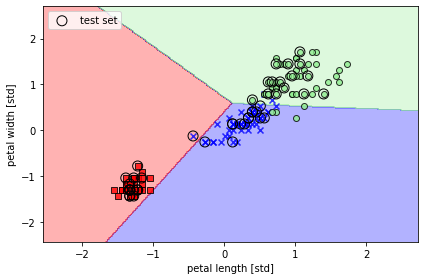

In [60]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X = X_combined_std,
                      y = y_combined,
                      classifier = ppn,
                      test_idx = range(105, 150))
plt.xlabel('petal length [std]')
plt.ylabel('petal width [std]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

## Logistic Regression

The perceptron never gonverge if the classes har not linearly seperable. The above plot shows a scenario where the classes _cannot_ be separated linearly, hence the Perceptron will _never_ converge. 

To solve this issue we will now investigate __logistic regression__. Note that logistic regression is a model for classification, and not regression. Just as the perceptron and Adaline, logistic regression is a _linear model_ for binary classification but it performs very well on linearly seperable classes.

To understand logistic regression, we need to introduce the concept of __ods__. Logistic regression is a probabilistic model for binary classification, where the ods of a particular event with the positive probability (e.g. class label y=1 etc) $p$ can be written as:

$$ \frac{p}{1 - p}$$

Further, we define the _logit_ function, or the _log-odds_ as:

$$ logit(p) = log \frac{p}{(1 - p)} ,$$

where $log$ is the _natural_ logarithm. Note that 

$$ D_{logit(p)} \in [0,\; 1],$$

while

$$ V_{logit(p)} \in \mathbb{R} $$.



This enables us to express a linear relationship between feature values and the log-odds:

$$ logit(p(y = 1|x)) = \vec{w}^{T} \vec{x} $$.

The probability that an example belongs to a perticular class is the inverse form of the logit function, which is known as the __logistic sigmoid function__, or often just the __sigmoid function__:

$$ \phi (z) = \frac{1}{1 + e^{-z}},$$

where $z$ is the net input.


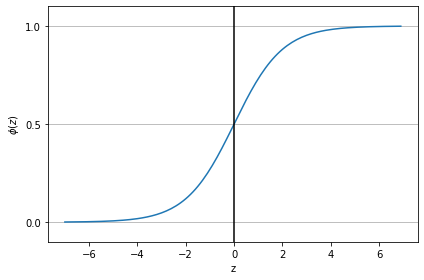

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1/(1 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()



We can now easily build the forward pass of a logistic regression model, by using a model similar to Adaline, but where the activation function is the sigmoid. Our threshold function can then map values > 0.5 as class 1 and values < 0.5 as class 0. This is natural, since the output from the sigmoid function is the probability that that particular example has class 1. 